# Suicidal Ideation Pt 1

Package Installation

In [3]:
!pip install torch_geometric
!pip install optuna
!pip install umap-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import roc_auc_score, accuracy_score
import random
from torch.optim import Adam
from torch_geometric.utils import negative_sampling, train_test_split_edges
from torch_geometric.nn import SAGEConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import optuna
import random
import shutil
import os
from torch_geometric.transforms import RandomLinkSplit
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
import seaborn as sns


# Data Preprocessing

In [6]:
csv_file_path = '/features_final.csv'
data_features = pd.read_csv(csv_file_path)
data_features
data_features_2 = data_features.copy()
data_features_2

,age,siblings,household,military_join,deployments,race_1,race_2,race_3,race_4,race_5,...,mos_91X,mos_91b,mos_91m,mos_92A,mos_92F,mos_92Y,mos_92y,mos_Infantry,deploy_ever_0,deploy_ever_1
0,0.303030,0.000000,0.058824,0.999001,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0.060606,1.000000,0.117647,0.999500,0.0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0.090909,0.071429,0.117647,0.998501,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0.121212,0.214286,0.176471,0.999500,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0.090909,0.357143,0.176471,0.998002,0.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.030303,0.285714,0.235294,1.000000,0.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
238,0.030303,0.214286,0.235294,0.999500,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
239,0.060606,0.071429,0.176471,0.999001,0.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
240,0.181818,0.285714,0.352941,0.998002,0.2,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True


In [7]:
data_features.index = data_features.index.astype(int)
new_index = pd.RangeIndex(start=0, stop=251, step=1)
df_reindexed = data_features.reindex(new_index, fill_value=0)
bool_columns = data_features.select_dtypes(include=bool).columns
df_reindexed[bool_columns] = df_reindexed[bool_columns].fillna(False)
df_reindexed
x = torch.tensor(df_reindexed.values.astype(np.float32))
x

tensor([[0.3030, 0.0000, 0.0588,  ..., 0.0000, 1.0000, 0.0000],
        [0.0606, 1.0000, 0.1176,  ..., 0.0000, 1.0000, 0.0000],
        [0.0909, 0.0714, 0.1176,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [8]:
df = pd.read_csv('/confident_edgelist2.csv')
edge_index = torch.tensor([df['pid'], df['alter']], dtype=torch.long)
print(edge_index)

tensor([[  2,   2,   3,   3,   3,   4,   5,   5,   8,   8,   8,   9,  10,  13,
          13,  13,  17,  17,  18,  21,  22,  25,  25,  29,  30,  30,  30,  32,
          32,  32,  33,  33,  33,  36,  36,  41,  44,  44,  46,  46,  46,  46,
          46,  46,  50,  50,  50,  54,  54,  54,  54,  56,  65,  71,  71,  71,
          71,  71,  71,  73,  73,  74,  76,  78,  79,  81,  81,  81,  82,  82,
          84,  86,  87,  87,  91,  92,  93,  98,  99,  99, 101, 102, 109, 111,
         111, 114, 119, 122, 130, 130, 132, 133, 133, 133, 133, 133, 133, 134,
         136, 137, 137, 137, 138, 139, 139, 139, 140, 140, 140, 142, 143, 143,
         143, 144, 145, 145, 145, 146, 146, 147, 148, 148, 148, 148, 150, 150,
         151, 154, 154, 154, 154, 157, 158, 160, 160, 161, 163, 168, 168, 170,
         170, 170, 171, 172, 178, 181, 182, 184, 184, 184, 184, 191, 199, 199,
         199, 201, 203, 213, 214, 216, 216, 216, 218, 218, 218, 220, 222, 223,
         223, 224, 225, 226, 226, 226, 226, 233, 233

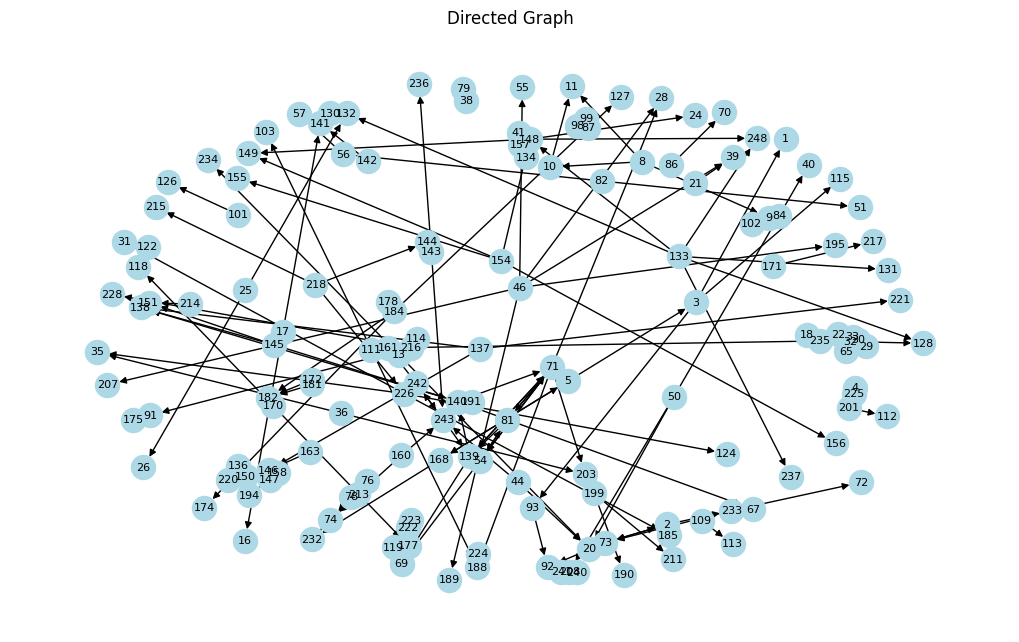

In [9]:
G = nx.from_pandas_edgelist(df, source='pid', target='alter', create_using=nx.DiGraph)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_size=300, node_color='lightblue', font_size=8)
plt.title('Directed Graph')
plt.show()

In [10]:
x = torch.tensor(df_reindexed.values.astype(np.float32))
edge_index = torch.tensor([df['pid'], df['alter']], dtype=torch.long)

# Decision Tree (Accuracy Baseline)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import pandas as pd

def prepare_data_with_node_mapping(x, edge_index):
    pos_edge_index = edge_index.T
    neg_edge_index = negative_sampling(
        edge_index=torch.tensor(edge_index),
        num_nodes=x.shape[0],
        num_neg_samples=pos_edge_index.shape[0]
    ).T

    all_edges = np.concatenate([pos_edge_index, neg_edge_index], axis=0)
    labels = np.concatenate([np.ones(pos_edge_index.shape[0]), np.zeros(neg_edge_index.shape[0])])

    features = np.hstack([x[all_edges[:, 0]], x[all_edges[:, 1]]])

    # Create a mapping of feature indices to nodes
    node_mapping = []
    for edge in all_edges:
        node_mapping.append((edge[0], edge[1]))

    return features, labels, node_mapping

def test_decision_tree(train_features, train_labels, test_features, test_labels, feature_names=None, node_mapping=None):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(train_features, train_labels)

    test_preds = clf.predict(test_features)
    test_probs = clf.predict_proba(test_features)

    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds)
    recall = recall_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds)
    auc = roc_auc_score(test_labels, test_probs[:, 1])

    # Get feature importances
    importances = clf.feature_importances_

    # Sort features by importance score
    importance_indices = np.argsort(importances)[::-1]

    # Filter features with importance greater than 0
    relevant_indices = [i for i in importance_indices if importances[i] > 0]

    # Get top features and their importance scores
    top_feature_indices = relevant_indices[:10]  # Adjust as needed
    top_feature_importances = importances[top_feature_indices]

    if feature_names is not None:
        # Ensure the feature_names list matches the number of features
        feature_names = feature_names[:len(train_features[0])]
        top_feature_names = [feature_names[i] for i in top_feature_indices if i < len(feature_names)]
    else:
        top_feature_names = [f'Feature_{i}' for i in top_feature_indices]  # Default names if feature_names is None

    # Create node information if node_mapping is provided
    if node_mapping is not None:
        top_feature_node_mapping = [(node_mapping[i][0], node_mapping[i][1]) for i in top_feature_indices if i < len(node_mapping)]
    else:
        top_feature_node_mapping = None

    # Export decision tree rules
    try:
        tree_rules = export_text(clf, feature_names=feature_names)
    except ValueError as e:
        print(f"Error exporting tree rules: {e}")
        tree_rules = None

    return auc, accuracy, precision, recall, f1, top_feature_names, top_feature_importances, top_feature_node_mapping, tree_rules

# Test the function
num_splits = 10
total_auc, total_accuracy, total_precision, total_recall, total_f1 = 0, 0, 0, 0, 0
all_top_feature_names = []
all_top_feature_importances = []
all_top_feature_node_mapping = []
all_tree_rules = []

for _ in range(num_splits):
    data_random_split = Data(x=x, edge_index=edge_index)
    split = RandomLinkSplit(num_val=0.2, num_test=0.2)
    train_data, val_data, test_data = split(data_random_split)

    # Prepare features and labels for training and testing
    train_features, train_labels, train_node_mapping = prepare_data_with_node_mapping(train_data.x.numpy(), train_data.edge_index.numpy())
    test_features, test_labels, test_node_mapping = prepare_data_with_node_mapping(test_data.x.numpy(), test_data.edge_index.numpy())

    # Assuming feature_names is the column names from data_features_2
    feature_names = data_features_2.columns.tolist()  # Ensure this matches your data

    # Evaluate the decision tree
    auc, accuracy, precision, recall, f1, top_feature_names, top_feature_importances, top_feature_node_mapping, tree_rules = test_decision_tree(
        train_features, train_labels, test_features, test_labels, feature_names, test_node_mapping
    )
    total_auc += auc
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1

    if top_feature_names is not None:
        all_top_feature_names.extend(top_feature_names)
        all_top_feature_importances.extend(top_feature_importances)
        all_top_feature_node_mapping.extend(top_feature_node_mapping)

    if tree_rules is not None:
        all_tree_rules.append(tree_rules)

# Calculate average metrics
average_auc = total_auc / num_splits
average_accuracy = total_accuracy / num_splits
average_precision = total_precision / num_splits
average_recall = total_recall / num_splits
average_f1 = total_f1 / num_splits

# Get unique top features and their total importance scores
top_feature_names, top_feature_importances = zip(*sorted(zip(all_top_feature_names, all_top_feature_importances), key=lambda x: x[1], reverse=True))
top_feature_names = list(top_feature_names)
top_feature_importances = list(top_feature_importances)

# Keep only top 10 features with non-zero importance
top_features = list(zip(top_feature_names, top_feature_importances))
top_features = [f for f in top_features if f[1] > 0][:10]
top_feature_names, top_feature_importances = zip(*top_features) if top_features else ([], [])

print(f'Average Metrics on Random Splits of Test Graphs - AUC: {average_auc:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}, Recall: {average_recall:.4f}, F1 Score: {average_f1:.4f}')

# Display top features with associated node pairs
for name, importance in zip(top_feature_names, top_feature_importances):
    # Find all indices related to the feature name
    related_node_mappings = []
    for idx, top_name in enumerate(all_top_feature_names):
        if top_name == name:
            related_node_mappings.append(all_top_feature_node_mapping[idx])

    print(f'Top Feature - Name: {name}, Importance: {importance}')
    printed_count = 0
    for mapping in related_node_mappings:
        if printed_count >= 3:  # Print only 1-3 node pairs
            break

        source_node, dest_node = mapping

        # Find feature values in the original dataframe (data_features_2)
        source_features = data_features_2.iloc[source_node].to_dict()
        dest_features = data_features_2.iloc[dest_node].to_dict()

        # Filter attributes with True values
        source_true_features = {k: v for k, v in source_features.items() if v is True}
        dest_true_features = {k: v for k, v in dest_features.items() if v is True}

        print(f'   Node Pair: ({source_node}, {dest_node})')
        print(f'     Source Node True Feature Values:')
        if source_true_features:
            print(pd.DataFrame(list(source_true_features.items()), columns=['Feature', 'Value']).to_string(index=False))
        else:
            print('     No True features in source node.')

        print(f'     Destination Node True Feature Values:')
        if dest_true_features:
            print(pd.DataFrame(list(dest_true_features.items()), columns=['Feature', 'Value']).to_string(index=False))
        else:
            print('     No True features in destination node.')

        # Indicate which node the important feature came from
        if name in source_true_features:
            print(f'     Important feature came from source node.')
        if name in dest_true_features:
            print(f'     Important feature came from destination node.')

        printed_count += 1

# Print decision tree rules for each split
for i, rules in enumerate(all_tree_rules):
    print(f'\nDecision Tree Rules for Split {i+1}:')
    print(rules)


Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Error exporting tree rules: feature_names must contain 290 elements, got 145
Average Metrics on Random Splits of Test Graphs - AUC: 0.7057, Accuracy: 0.7057, Precision: 0.6508, Recall: 0.8953, F1 Score: 0.7532
Top Feature - Name: age, Importance: 0.1369006172703195


IndexError: single positional indexer is out-of-bounds

In [ ]:
from sklearn.tree import DecisionTreeClassifier, _tree

def describe_tree_splits(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    splits_description = []

    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            value = tree_.value[node]

            # Class distribution at the current node
            class_counts = value[0]
            total_samples = class_counts.sum()
            class_percentages = class_counts / total_samples * 100

            splits_description.append(
                f"Split: {name} (samples: {total_samples:.0f}, "
                f"class percentages: [Class 0: {class_percentages[0]:.2f}%, "
                f"Class 1: {class_percentages[1]:.2f}%])"
            )

            # Traverse the left and right child nodes
            recurse(tree_.children_left[node], depth + 1)
            recurse(tree_.children_right[node], depth + 1)
        else:
            value = tree_.value[node]
            class_counts = value[0]
            total_samples = class_counts.sum()
            class_percentages = class_counts / total_samples * 100
            splits_description.append(
                f"Leaf: (samples: {total_samples:.0f}, "
                f"class percentages: [Class 0: {class_percentages[0]:.2f}%, "
                f"Class 1: {class_percentages[1]:.2f}%])"
            )

    recurse(0, 0)
    return splits_description

def test_decision_tree_with_splits(train_features, train_labels, feature_names=None):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(train_features, train_labels)

    # Ensure feature_names list matches the number of features in the classifier
    num_features = train_features.shape[1]
    if feature_names is not None and len(feature_names) != num_features:
        print(f"Warning: Feature names list length ({len(feature_names)}) does not match number of features ({num_features})")
        feature_names = [f'Feature_{i}' for i in range(num_features)]

    # Describe the splits in the decision tree
    try:
        splits_description = describe_tree_splits(clf, feature_names)
    except ValueError as e:
        print(f"Error describing tree splits: {e}")
        splits_description = None

    return splits_description

# Test the function
num_splits = 1
all_splits_descriptions = []

for _ in range(num_splits):
    data_random_split = Data(x=x, edge_index=edge_index)
    split = RandomLinkSplit(num_val=0.2, num_test=0.2)
    train_data, val_data, test_data = split(data_random_split)

    # Prepare features and labels for training
    train_features, train_labels, _ = prepare_data_with_node_mapping(train_data.x.numpy(), train_data.edge_index.numpy())

    # Generate feature names for both source and destination
    original_feature_names = data_features_2.columns.tolist()
    feature_names = original_feature_names * 2  # Duplicate for source and destination features

    # Evaluate the decision tree
    splits_description = test_decision_tree_with_splits(train_features, train_labels, feature_names)
    if splits_description is not None:
        all_splits_descriptions.append(splits_description)

# Print the splits description for each decision tree
for i, splits in enumerate(all_splits_descriptions):
    print(f'\nDecision Tree Splits Description for Split {i+1}:')
    for split in splits:
        print(split)



Decision Tree Splits Description for Split 1:
Split: romantic_1 (samples: 224, class percentages: [Class 0: 50.00%, Class 1: 50.00%])
Split: sexuality_1 (samples: 69, class percentages: [Class 0: 65.22%, Class 1: 34.78%])
Leaf: (samples: 4, class percentages: [Class 0: 0.00%, Class 1: 100.00%])
Split: siblings (samples: 65, class percentages: [Class 0: 69.23%, Class 1: 30.77%])
Split: mom_ed_9 (samples: 46, class percentages: [Class 0: 80.43%, Class 1: 19.57%])
Split: dad_ed_10 (samples: 35, class percentages: [Class 0: 91.43%, Class 1: 8.57%])
Split: ed_7 (samples: 34, class percentages: [Class 0: 94.12%, Class 1: 5.88%])
Split: rank_E-8 (samples: 33, class percentages: [Class 0: 96.97%, Class 1: 3.03%])
Leaf: (samples: 31, class percentages: [Class 0: 100.00%, Class 1: 0.00%])
Split: mom_ed_5 (samples: 2, class percentages: [Class 0: 50.00%, Class 1: 50.00%])
Leaf: (samples: 1, class percentages: [Class 0: 0.00%, Class 1: 100.00%])
Leaf: (samples: 1, class percentages: [Class 0: 100

# GraphSage Model with binary cross entropy loss

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv
from torch.optim import AdamW
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.conv_out = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_out(x, edge_index)
        return x

    def encode(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_out(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return torch.sigmoid(self.decode(z, edge_index))

def train_model(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_index.size(1)
    )

    pos_pred = torch.sigmoid(model.decode(z, pos_edge_index))
    neg_pred = torch.sigmoid(model.decode(z, neg_edge_index))

    pos_labels = torch.ones(pos_pred.size(0), dtype=torch.float).to(device)
    neg_labels = torch.zeros(neg_pred.size(0), dtype=torch.float).to(device)

    pos_loss = -torch.log(pos_pred).mean()
    neg_loss = -torch.log(1 - neg_pred).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    all_preds = torch.cat([pos_pred, neg_pred])
    all_labels = torch.cat([pos_labels, neg_labels])

    all_preds_binary = (all_preds > 0.5).float()
    accuracy = (all_preds_binary == all_labels).float().mean().item()

    return loss.item(), accuracy, z

def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Hyperparameters
hidden_channels = 87
lr = 0.0006319720394446876
num_layers = 3
dropout = 0.09011363149848563
epochs = 6465
weight_decay = 1.5091468730235952e-09
out_channels = 7

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

x = torch.tensor(df_reindexed.values.astype(np.float32))
edge_index = torch.tensor([df['pid'].values, df['alter'].values], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)
split = RandomLinkSplit(num_val=0.1, num_test=0.1)
train_data, val_data, test_data = split(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_selected = Data(x=x, edge_index=train_data.edge_index)
val_data_selected = Data(x=x, edge_index=val_data.edge_index)
test_data_selected = Data(x=x, edge_index=test_data.edge_index)

model = GraphSAGE(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    loss, accuracy, embeddings = train_model(model, train_data_selected, optimizer)
    if epoch % 100 == 0:  # Print every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Save embeddings
embeddings_save_dir = '/content/embeddings'
clear_directory(embeddings_save_dir)

embeddings_path = os.path.join(embeddings_save_dir, f"embeddings.pt")
torch.save(embeddings, embeddings_path)
print(f"Embeddings saved to {embeddings_path}")


# GAT implementation


In [13]:
import torch
import numpy as np
import pandas as pd
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GATConv
from torch.optim import AdamW
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

# Define GraphGAT model
class GraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads):
        super(GraphGAT, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.conv_out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_out(x, edge_index)
        return x

    def encode(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_out(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return torch.sigmoid(self.decode(z, edge_index))

def train_model(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_index.size(1)
    )

    # Calculate the loss
    pos_pred = torch.sigmoid(model.decode(z, pos_edge_index))
    neg_pred = torch.sigmoid(model.decode(z, neg_edge_index))

    pos_loss = -torch.log(pos_pred).mean()
    neg_loss = -torch.log(1 - neg_pred).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    # Calculate accuracy
    pos_labels = torch.ones(pos_pred.size(0), dtype=torch.float).to(device)
    neg_labels = torch.zeros(neg_pred.size(0), dtype=torch.float).to(device)

    all_preds = torch.cat([pos_pred, neg_pred])
    all_labels = torch.cat([pos_labels, neg_labels])

    all_preds_binary = (all_preds > 0.5).float()
    accuracy = (all_preds_binary == all_labels).float().mean().item()

    return loss.item(), accuracy, z

def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Hyperparameters
hidden_channels = 16
lr = 0.000959692457912392
num_layers = 1
dropout = 0.062244324375886104
epochs = 8558
weight_decay = 1.7012057072377146e-09
out_channels = 7
heads = 8

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

# Assuming df_reindexed and df are defined previously
x = torch.tensor(df_reindexed.values.astype(np.float32))
edge_index = torch.tensor([df['pid'].values, df['alter'].values], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)
split = RandomLinkSplit(num_val=0.2, num_test=0.1)
train_data, val_data, test_data = split(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_selected = Data(x=x, edge_index=train_data.edge_index)
val_data_selected = Data(x=x, edge_index=val_data.edge_index)
test_data_selected = Data(x=x, edge_index=test_data.edge_index)

model = GraphGAT(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout,
    heads = heads
).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    loss, accuracy, embeddings = train_model(model, train_data_selected, optimizer)
    if epoch % 100 == 0:  # Print every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Save embeddings
embeddings_save_dir = '/content/embeddings'
clear_directory(embeddings_save_dir)

embeddings_path = os.path.join(embeddings_save_dir, f"embeddings.pt")
torch.save(embeddings, embeddings_path)
print(f"Embeddings saved to {embeddings_path}")

# Save the GraphGAT model
model_save_path = '/content/graphgat_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


<ipython-input-13-c07f311f1539>:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor([df['pid'].values, df['alter'].values], dtype=torch.long)


Epoch 100, Loss: 0.9620, Accuracy: 0.7577
Epoch 200, Loss: 0.8608, Accuracy: 0.7538
Epoch 300, Loss: 0.8415, Accuracy: 0.7346
Epoch 400, Loss: 0.9094, Accuracy: 0.7308
Epoch 500, Loss: 0.8612, Accuracy: 0.7385
Epoch 600, Loss: 0.8973, Accuracy: 0.7346
Epoch 700, Loss: 0.8443, Accuracy: 0.7077
Epoch 800, Loss: 0.8177, Accuracy: 0.7423
Epoch 900, Loss: 0.8459, Accuracy: 0.7231
Epoch 1000, Loss: 0.8144, Accuracy: 0.7385
Epoch 1100, Loss: 0.8046, Accuracy: 0.7462
Epoch 1200, Loss: 0.7942, Accuracy: 0.7423
Epoch 1300, Loss: 0.7732, Accuracy: 0.7615
Epoch 1400, Loss: 0.8420, Accuracy: 0.7308
Epoch 1500, Loss: 0.7830, Accuracy: 0.7731
Epoch 1600, Loss: 0.7753, Accuracy: 0.8038
Epoch 1700, Loss: 0.8713, Accuracy: 0.7654
Epoch 1800, Loss: 0.7568, Accuracy: 0.7769
Epoch 1900, Loss: 0.7492, Accuracy: 0.7885
Epoch 2000, Loss: 0.8377, Accuracy: 0.7385
Epoch 2100, Loss: 0.8232, Accuracy: 0.7462
Epoch 2200, Loss: 0.8718, Accuracy: 0.7231
Epoch 2300, Loss: 0.8059, Accuracy: 0.7615
Epoch 2400, Loss: 0.

# Embedding visualisation

<ipython-input-28-5488a18b3ad0>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embeddings_path)
/usr/local/lib/python3.10/dist-packages/umap/umap_

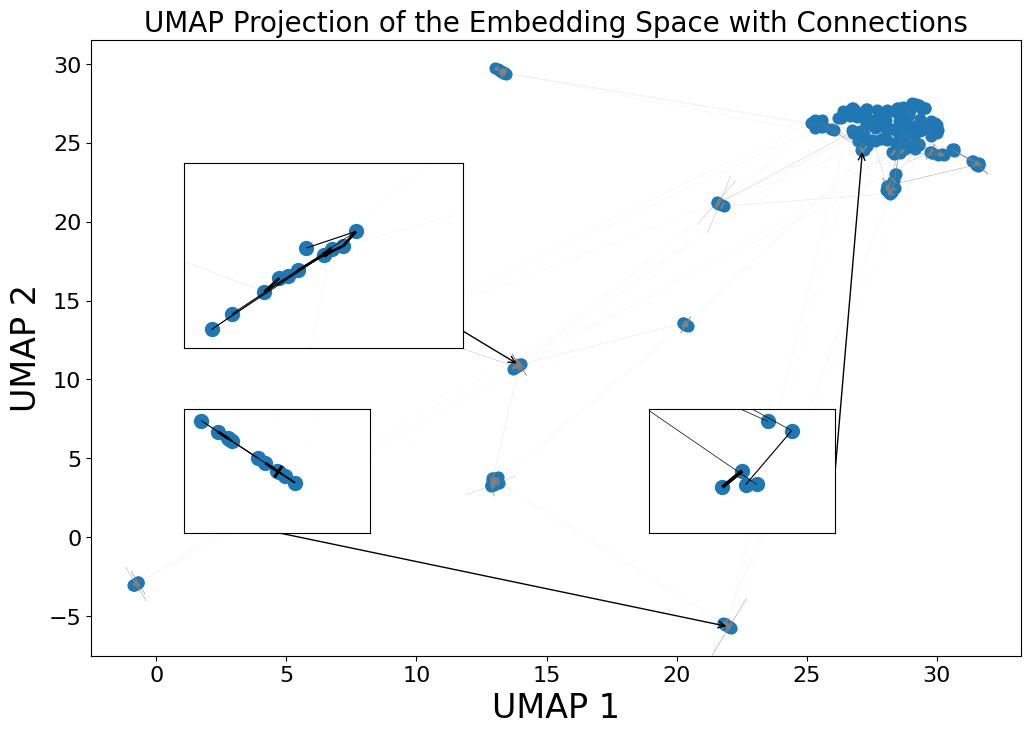

In [28]:
import torch
import os
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from torch_geometric.utils import to_networkx
from sklearn.metrics import pairwise_distances

# Load the embeddings
embeddings_path = os.path.join(embeddings_save_dir, "embeddings.pt")
embeddings = torch.load(embeddings_path)
embeddings_np = embeddings.detach().cpu().numpy()

# Reduce dimensions to 2D using UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings_np)

# Plot the 2D embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=60, cmap='Spectral', alpha=1)

# Define edges and lines for connections
edges = edge_index.t().cpu().numpy()
lines = []
line_widths = []
connection_counts = np.zeros(len(embedding_2d))  # Track the number of connections for each point

# Calculate the distances between connected embeddings
for edge in edges:
    point1 = embedding_2d[edge[0]]
    point2 = embedding_2d[edge[1]]
    distance = np.linalg.norm(point1 - point2)

    # Invert the distance to get a thicker line for closer embeddings
    linewidth = 0.5 / (distance + 1e-5)  # Reduce the line thickness
    lines.append((point1, point2))
    line_widths.append(linewidth)

    # Count the number of connections for each point
    connection_counts[edge[0]] += 1
    connection_counts[edge[1]] += 1

# Add the lines to the main plot
lc = LineCollection(lines, color='gray', alpha=1, linewidths=line_widths)
plt.gca().add_collection(lc)

plt.title('UMAP Projection of the Embedding Space with Connections', fontsize=20)
plt.xlabel('UMAP 1', fontsize=24)
plt.ylabel('UMAP 2', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Create three inset plots: many, few, and normal connections
ax_inset_many = plt.gca().inset_axes([0.1, 0.5, 0.3, 0.3])  # Inset plot for many connections (left side)
ax_inset_few = plt.gca().inset_axes([0.6, 0.2, 0.2, 0.2])  # Inset plot for few connections (bottom right)
ax_inset_normal = plt.gca().inset_axes([0.1, 0.2, 0.2, 0.2])  # Inset plot for normal connections (top right)

# Find the index for a cluster with many connections
cluster_many_idx = np.argmax(connection_counts)  # Cluster with the most connections

# Find the index for a cluster with few connections (at least 2-3 connections)
few_connections_idxs = np.where(connection_counts >= 2)[0]  # Clusters with at least 2 connections
cluster_few_idx = few_connections_idxs[np.argmin(connection_counts[few_connections_idxs])]  # Cluster with the fewest among those with at least 2 connections

# Find the index for a cluster with a normal amount of connections
median_connections = np.median(connection_counts)
normal_connections_idxs = np.where(connection_counts > 2)[0]  # Clusters with more than 2 connections
normal_connections_diffs = np.abs(connection_counts[normal_connections_idxs] - median_connections)  # Difference from median
cluster_normal_idx = normal_connections_idxs[np.argmin(normal_connections_diffs)]  # Cluster closest to median

# Define zoom level and limits for the inset plots
zoom_level = 0.3

# Inset plot for many connections
center_point_many = embedding_2d[cluster_many_idx]
xlim_many = [center_point_many[0] - zoom_level, center_point_many[0] + zoom_level]
ylim_many = [center_point_many[1] - zoom_level, center_point_many[1] + zoom_level]

ax_inset_many.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=100, cmap='Spectral', alpha=1)
ax_inset_many.set_xlim(xlim_many)
ax_inset_many.set_ylim(ylim_many)

# Add lines for connections in the 'many connections' inset plot
cluster_lines_many = []
cluster_line_widths_many = []
for line, lw in zip(lines, line_widths):
    if (xlim_many[0] <= line[0][0] <= xlim_many[1] and ylim_many[0] <= line[0][1] <= ylim_many[1]) or \
       (xlim_many[0] <= line[1][0] <= xlim_many[1] and ylim_many[0] <= line[1][1] <= ylim_many[1]):
        cluster_lines_many.append(line)
        cluster_line_widths_many.append(lw * 0.2)  # Further reduce line thickness in the inset

lc_many = LineCollection(cluster_lines_many, color='black', alpha=1, linewidths=cluster_line_widths_many)
ax_inset_many.add_collection(lc_many)

ax_inset_many.set_xticks([])
ax_inset_many.set_yticks([])

# Inset plot for few connections
center_point_few = embedding_2d[cluster_few_idx]
xlim_few = [center_point_few[0] - zoom_level, center_point_few[0] + zoom_level]
ylim_few = [center_point_few[1] - zoom_level, center_point_few[1] + zoom_level]

ax_inset_few.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=100, cmap='Spectral', alpha=1)
ax_inset_few.set_xlim(xlim_few)
ax_inset_few.set_ylim(ylim_few)

# Add lines for connections in the 'few connections' inset plot
cluster_lines_few = []
cluster_line_widths_few = []
for line, lw in zip(lines, line_widths):
    if (xlim_few[0] <= line[0][0] <= xlim_few[1] and ylim_few[0] <= line[0][1] <= ylim_few[1]) or \
       (xlim_few[0] <= line[1][0] <= xlim_few[1] and ylim_few[0] <= line[1][1] <= ylim_few[1]):
        cluster_lines_few.append(line)
        cluster_line_widths_few.append(max(lw * 0.5, 0.5))  # Ensure line thickness is visible

lc_few = LineCollection(cluster_lines_few, color='black', alpha=1, linewidths=cluster_line_widths_few)
ax_inset_few.add_collection(lc_few)

ax_inset_few.set_xticks([])
ax_inset_few.set_yticks([])



# Inset plot for normal connections
center_point_normal = embedding_2d[cluster_normal_idx]
xlim_normal = [center_point_normal[0] - zoom_level, center_point_normal[0] + zoom_level]
ylim_normal = [center_point_normal[1] - zoom_level, center_point_normal[1] + zoom_level]

ax_inset_normal.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=100, cmap='Spectral', alpha=1)
ax_inset_normal.set_xlim(xlim_normal)
ax_inset_normal.set_ylim(ylim_normal)

# Add lines for connections in the 'normal connections' inset plot
cluster_lines_normal = []
cluster_line_widths_normal = []
for line, lw in zip(lines, line_widths):
    if (xlim_normal[0] <= line[0][0] <= xlim_normal[1] and ylim_normal[0] <= line[0][1] <= ylim_normal[1]) or \
       (xlim_normal[0] <= line[1][0] <= xlim_normal[1] and ylim_normal[0] <= line[1][1] <= ylim_normal[1]):
        cluster_lines_normal.append(line)
        cluster_line_widths_normal.append(lw * 0.2)  # Further reduce line thickness in the inset

lc_normal = LineCollection(cluster_lines_normal, color='black', alpha=1, linewidths=cluster_line_widths_normal)

lc_normal = LineCollection(cluster_lines_normal, color='black', alpha=1, linewidths=cluster_line_widths_normal)
ax_inset_normal.add_collection(lc_normal)

ax_inset_normal.set_xticks([])
ax_inset_normal.set_yticks([])

plt.annotate('', xy=(center_point_many[0], center_point_many[1]), xytext=(0.1, 0.8),
             xycoords='data', textcoords='axes fraction',
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12)

# Draw an arrow to point to the cluster with few connections
plt.annotate('', xy=(center_point_few[0], center_point_few[1]), xytext=(0.8, 0.3),
             xycoords='data', textcoords='axes fraction',
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12)

# Draw an arrow to point to the cluster with normal connections
plt.annotate('', xy=(center_point_normal[0], center_point_normal[1]), xytext=(0.2, 0.2),
             xycoords='data', textcoords='axes fraction',
             arrowprops=dict(facecolor='red', arrowstyle='->'), fontsize=12)

plt.show()


# Node disambiguation (Evaluation pipeline 1)

In [14]:
import torch
import os
import numpy as np
import umap
from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind

embeddings_path = os.path.join(embeddings_save_dir, "embeddings.pt")
#embeddings_path = '/embeddings.pt'
embeddings = torch.load(embeddings_path)
embeddings_np = embeddings.detach().cpu().numpy()

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(embeddings_np)

edges = edge_index.t().cpu().numpy()

linked_distances = []
for edge in edges:
    dist = np.linalg.norm(embedding_3d[edge[0]] - embedding_3d[edge[1]])
    linked_distances.append(dist)

linked_distances = np.array(linked_distances)

num_nodes = embedding_3d.shape[0]
all_pairs = np.array(np.triu_indices(num_nodes, k=1)).T

other_pairs = [pair for pair in all_pairs if not any((pair == edge).all() for edge in edges)]
other_pairs = np.array(other_pairs)

other_distances = []
for pair in other_pairs:
    dist = np.linalg.norm(embedding_3d[pair[0]] - embedding_3d[pair[1]])
    other_distances.append(dist)

other_distances = np.array(other_distances)

linked_mean = np.mean(linked_distances)
linked_std = np.std(linked_distances)
other_mean = np.mean(other_distances)
other_std = np.std(other_distances)

t_stat, p_value = ttest_ind(linked_distances, other_distances)

print(f"Linked pairs - Mean distance: {linked_mean}, Std Dev: {linked_std}")
print(f"Other pairs - Mean distance: {other_mean}, Std Dev: {other_std}")
print(f"T-test - t-statistic: {t_stat}, p-value: {p_value}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.hist(linked_distances, bins=50, alpha=0.5, label='Linked Pairs')
plt.hist(other_distances, bins=50, alpha=0.5, label='Other Pairs')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance Distribution in Embedding Space')
plt.show()


<ipython-input-14-973e2202d5ed>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embeddings_path)
/usr/local/lib/python3.10/dist-packages/umap/umap_

KeyboardInterrupt: 

# Pair disambiguation Simulation

In [ ]:
embeddings = embeddings.detach().numpy()

In [ ]:
#For GraphSage and GAT
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def onevsallpipeline1(embeddings, edgelist):
    edges = [(edgelist[0, i].item(), edgelist[1, i].item()) for i in range(edgelist.size(1))]
    nodes = np.unique(np.concatenate([edgelist[0].numpy(), edgelist[1].numpy()]))

    true_labels = []
    predicted_scores = []

    for edge in edges:
        u = edge[0]
        v1 = edge[1]

        not_connected_nodes = [v for v in nodes if (u, v) not in edges]

        for v2 in not_connected_nodes:
            emb_u = embeddings[u]
            emb_v1 = embeddings[v1]
            emb_v2 = embeddings[v2]

            # Compute euclidean distance between (u, v1) and (u, v2)
            dist1 = np.linalg.norm(emb_u - emb_v1)
            dist2 = np.linalg.norm(emb_u - emb_v2)

            # Assign score based on whether v1 or v2 is more likely
            true_label = 1  # Since v1 is the actual connected node
            predicted_score = 1 if dist1 < dist2 else 0

            true_labels.append(true_label)
            predicted_scores.append(predicted_score)

    accuracy = accuracy_score(true_labels, predicted_scores)
    precision = precision_score(true_labels, predicted_scores)
    recall = recall_score(true_labels, predicted_scores)
    f1 = f1_score(true_labels, predicted_scores)

    return {
        "accuracy": float("{:.4f}".format(accuracy)),
        "precision": float("{:.4f}".format(precision)),
        "recall": float("{:.4f}".format(recall)),
        "f1_score": float("{:.4f}".format(f1))
    }


In [ ]:
onevsallpipeline1(embeddings, edge_index)

{'accuracy': 0.888, 'precision': 1.0, 'recall': 0.888, 'f1_score': 0.9407}

In [ ]:
#For Decision tree
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, export_text
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import pandas as pd

def prepare_data_with_node_mapping(x, edge_index):
    pos_edge_index = edge_index.T
    neg_edge_index = negative_sampling(
        edge_index=torch.tensor(edge_index),
        num_nodes=x.shape[0],
        num_neg_samples=pos_edge_index.shape[0]
    ).T

    all_edges = np.concatenate([pos_edge_index, neg_edge_index], axis=0)
    labels = np.concatenate([np.ones(pos_edge_index.shape[0]), np.zeros(neg_edge_index.shape[0])])

    features = np.hstack([x[all_edges[:, 0]], x[all_edges[:, 1]]])

    # Create a mapping of feature indices to nodes
    node_mapping = []
    for edge in all_edges:
        node_mapping.append((edge[0], edge[1]))

    return features, labels, node_mapping

def test_decision_tree(train_features, train_labels, test_features, test_labels, feature_names=None, node_mapping=None):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(train_features, train_labels)

    test_preds = clf.predict(test_features)
    test_probs = clf.predict_proba(test_features)

    accuracy = accuracy_score(test_labels, test_preds)
    precision = precision_score(test_labels, test_preds)
    recall = recall_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds)
    auc = roc_auc_score(test_labels, test_probs[:, 1])

    importances = clf.feature_importances_
    importance_indices = np.argsort(importances)[::-1]
    relevant_indices = [i for i in importance_indices if importances[i] > 0]
    top_feature_indices = relevant_indices[:10]
    top_feature_importances = importances[top_feature_indices]

    if feature_names is not None:
        feature_names = feature_names[:len(train_features[0])]
        top_feature_names = [feature_names[i] for i in top_feature_indices if i < len(feature_names)]
    else:
        top_feature_names = [f'Feature_{i}' for i in top_feature_indices]

    if node_mapping is not None:
        top_feature_node_mapping = [(node_mapping[i][0], node_mapping[i][1]) for i in top_feature_indices if i < len(node_mapping)]
    else:
        top_feature_node_mapping = None

    try:
        tree_rules = export_text(clf, feature_names=feature_names)
    except ValueError as e:
        print(f"Error exporting tree rules: {e}")
        tree_rules = None

    return auc, accuracy, precision, recall, f1, top_feature_names, top_feature_importances, top_feature_node_mapping, tree_rules, clf

def onevsallpipeline1(clf, edge_index, x):
    edges = [(edge_index[0, i].item(), edge_index[1, i].item()) for i in range(edge_index.size(1))]
    nodes = np.unique(np.concatenate([edge_index[0].numpy(), edge_index[1].numpy()]))

    true_labels = []
    predicted_scores = []

    for edge in edges:
        u = edge[0]
        v1 = edge[1]

        not_connected_nodes = [v for v in nodes if (u, v) not in edges]

        for v2 in not_connected_nodes:

            feature_u_v1 = np.hstack([x[u], x[v1]])
            feature_u_v2 = np.hstack([x[u], x[v2]])

            prob_v1 = clf.predict_proba([feature_u_v1])[0][1]
            prob_v2 = clf.predict_proba([feature_u_v2])[0][1]

            true_label = 1
            predicted_score = 1 if prob_v1 > prob_v2 else 0

            true_labels.append(true_label)
            predicted_scores.append(predicted_score)

    accuracy = accuracy_score(true_labels, predicted_scores)
    precision = precision_score(true_labels, predicted_scores)
    recall = recall_score(true_labels, predicted_scores)
    f1 = f1_score(true_labels, predicted_scores)

    return {
        "accuracy": float("{:.4f}".format(accuracy)),
        "precision": float("{:.4f}".format(precision)),
        "recall": float("{:.4f}".format(recall)),
        "f1_score": float("{:.4f}".format(f1))
    }

# Test the function
num_splits = 10
total_auc, total_accuracy, total_precision, total_recall, total_f1 = 0, 0, 0, 0, 0
all_top_feature_names = []
all_top_feature_importances = []
all_top_feature_node_mapping = []
all_tree_rules = []

for _ in range(num_splits):
    data_random_split = Data(x=x, edge_index=edge_index)
    split = RandomLinkSplit(num_val=0.2, num_test=0.2)
    train_data, val_data, test_data = split(data_random_split)

    train_features, train_labels, train_node_mapping = prepare_data_with_node_mapping(train_data.x.numpy(), train_data.edge_index.numpy())
    test_features, test_labels, test_node_mapping = prepare_data_with_node_mapping(test_data.x.numpy(), test_data.edge_index.numpy())

    feature_names = data_features_2.columns.tolist()

    auc, accuracy, precision, recall, f1, top_feature_names, top_feature_importances, top_feature_node_mapping, tree_rules, clf = test_decision_tree(
        train_features, train_labels, test_features, test_labels, feature_names, test_node_mapping
    )
    total_auc += auc
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1

    if top_feature_names is not None:
        all_top_feature_names.extend(top_feature_names)
        all_top_feature_importances.extend(top_feature_importances)
        all_top_feature_node_mapping.extend(top_feature_node_mapping)

    if tree_rules is not None:
        all_tree_rules.append(tree_rules)

    simulation_results = onevsallpipeline1(clf, test_data.edge_index, test_data.x.numpy())

    print(f'Simulation Results - Accuracy: {simulation_results["accuracy"]}, Precision: {simulation_results["precision"]}, Recall: {simulation_results["recall"]}, F1 Score: {simulation_results["f1_score"]}')

average_auc = total_auc / num_splits
average_accuracy = total_accuracy / num_splits
average_precision = total_precision / num_splits
average_recall = total_recall / num_splits
average_f1 = total_f1 / num_splits

print(f'Average Metrics on Random Splits of Test Graphs - AUC: {average_auc:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}, Recall: {average_recall:.4f}, F1 Score: {average_f1:.4f}')

top_feature_names, top_feature_importances = zip(*sorted(zip(all_top_feature_names, all_top_feature_importances), key=lambda x: x[1], reverse=True))
top_feature_names = list(top_feature_names)
top_feature_importances = list(top_feature_importances)

top_features = list(zip(top_feature_names, top_feature_importances))
top_features = [f for f in top_features if f[1] > 0][:10]
top_feature_names, top_feature_importances = zip(*top_features) if top_features else ([], [])

print(f'Top Features - Names: {top_feature_names}, Importances: {top_feature_importances}')

for i, rules in enumerate(all_tree_rules):
    print(f'\nDecision Tree Rules for Split {i+1}:')
    print(rules)


Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3631, Precision: 1.0, Recall: 0.3631, F1 Score: 0.5327
Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3737, Precision: 1.0, Recall: 0.3737, F1 Score: 0.544
Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3893, Precision: 1.0, Recall: 0.3893, F1 Score: 0.5604
Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3415, Precision: 1.0, Recall: 0.3415, F1 Score: 0.5092
Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3108, Precision: 1.0, Recall: 0.3108, F1 Score: 0.4742
Error exporting tree rules: feature_names must contain 290 elements, got 145
Simulation Results - Accuracy: 0.3054, Precision: 1.0, Recall: 0.3054, F1 Score: 0.4679
Error expor

# Link Existence Simulation

In [17]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def test(data, model):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x.to(device), data.edge_index.to(device))

        pos_edge_index = data.edge_label_index[:, data.edge_label == 1].to(device)
        neg_edge_index = data.edge_label_index[:, data.edge_label == 0].to(device)

        pos_y = torch.ones(pos_edge_index.size(1)).to(device)
        neg_y = torch.zeros(neg_edge_index.size(1)).to(device)
        y = torch.cat([pos_y, neg_y], dim=0).to(device)

        pos_pred = model.decode(z, pos_edge_index)
        neg_pred = model.decode(z, neg_edge_index)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        if torch.isnan(pred).any():
            return float('-inf'), float('-inf'), float('-inf'), float('-inf'), float('-inf')

        auc = roc_auc_score(y.cpu().numpy(), pred.cpu().detach().numpy())
        pred_labels = (pred > 0.5).float()  # Change to 0.5 threshold
        accuracy = accuracy_score(y.cpu().numpy(), pred_labels.cpu().detach().numpy())
        precision = precision_score(y.cpu().numpy(), pred_labels.cpu().detach().numpy())
        recall = recall_score(y.cpu().numpy(), pred_labels.cpu().detach().numpy())
        f1 = f1_score(y.cpu().numpy(), pred_labels.cpu().detach().numpy())

    return auc, accuracy, precision, recall, f1

def generate_test_graphs(current_data, num_graphs, transform):
    test_graphs = []
    for _ in range(num_graphs):
        train_data, val_data, test_data = transform(current_data)
        test_graphs.append(test_data)
    return test_graphs

num_splits = 10
total_auc, total_accuracy, total_precision, total_recall, total_f1 = 0, 0, 0, 0, 0

for _ in range(num_splits):
    data_random_split = Data(x=x, edge_index=edge_index)
    train_data, val_data, test_data = split(data_random_split)

    # Ensure test_data contains the necessary attributes
    if hasattr(test_data, 'edge_label_index') and hasattr(test_data, 'edge_label'):
        test_graphs = generate_test_graphs(data_random_split, num_graphs=num_splits, transform=split)

        for test_graph in test_graphs:
            auc, accuracy, precision, recall, f1 = test(test_graph, model)
            total_auc += auc
            total_accuracy += accuracy
            total_precision += precision
            total_recall += recall
            total_f1 += f1

average_auc = total_auc / (num_splits * num_splits)
average_accuracy = total_accuracy / (num_splits * num_splits)
average_precision = total_precision / (num_splits * num_splits)
average_recall = total_recall / (num_splits * num_splits)
average_f1 = total_f1 / (num_splits * num_splits)

print(f'Average Metrics on Random Splits of Test Graphs - AUC: {average_auc:.4f}, Accuracy: {average_accuracy:.4f}, Precision: {average_precision:.4f}, Recall: {average_recall:.4f}, F1 Score: {average_f1:.4f}')


Average Metrics on Random Splits of Test Graphs - AUC: 0.8127, Accuracy: 0.7886, Precision: 0.9018, Recall: 0.6489, F1 Score: 0.7493


# Results
Evaluation Pipeline 1 (Node Disambiguation): 0.9024

Pipeline 1 with GAT: 0.9169


Pipeline 2 using GAT: Average Metrics on Random Splits of Test Graphs - AUC: 0.8349, Accuracy: 0.8011, Precision: 0.6566, Recall: 0.8439, F1 Score: 0.7362

Baseline accuracy with decision tree: 0.69

# Real ambiguous data

In [ ]:
ambig_res = pd.read_csv('/ambig_res_edgelist.csv')
features = pd.read_csv('/features_final.csv')

In [ ]:
features.index = features.index.astype(int)
new_index = pd.RangeIndex(start=0, stop=251, step=1)
df_reindexed = features.reindex(new_index, fill_value=0)
bool_columns = features.select_dtypes(include=bool).columns
df_reindexed[bool_columns] = df_reindexed[bool_columns].fillna(False)
df_reindexed
x = torch.tensor(df_reindexed.values.astype(np.float32))
x

tensor([[0.3030, 0.0000, 0.0588,  ..., 0.0000, 1.0000, 0.0000],
        [0.0606, 1.0000, 0.1176,  ..., 0.0000, 1.0000, 0.0000],
        [0.0909, 0.0714, 0.1176,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
import pandas as pd
import torch

# Load the CSV file
confident_edges = pd.read_csv('/confident_edgelist2.csv')

ambig_res = pd.read_csv('/ambig_res_edgelist.csv')
pids_to_remove = set(ambig_res['pid'])

confident_edges_filtered = confident_edges[~confident_edges['pid'].isin(pids_to_remove)]

pids = confident_edges_filtered['pid'].to_numpy()
alters = confident_edges_filtered['alter'].to_numpy()

edge_index = torch.tensor([pids, alters], dtype=torch.long)

print(edge_index)




tensor([[  5,   5,   8,   8,   8,   9,  13,  13,  13,  17,  17,  18,  21,  22,
          30,  30,  30,  32,  32,  32,  33,  33,  33,  41,  44,  44,  46,  46,
          46,  46,  46,  46,  65,  76,  78,  82,  82,  86,  87,  87,  91,  92,
          98,  99,  99, 101, 102, 109, 119, 122, 130, 130, 132, 133, 133, 133,
         133, 133, 133, 136, 138, 142, 143, 143, 143, 145, 145, 145, 146, 146,
         148, 148, 148, 148, 150, 150, 151, 157, 158, 161, 163, 168, 168, 170,
         170, 170, 172, 178, 181, 184, 184, 184, 184, 199, 199, 199, 201, 214,
         216, 216, 216, 218, 218, 218, 222, 223, 223, 224, 225, 226, 226, 226,
         226, 240, 241, 242, 242, 243, 243],
        [  3, 168,   9,  11,  10,  84,  20, 161, 234,  16, 141,  30,  39,  32,
          29,  33,  32,  29,  33,  22,  32,  30,  29, 148, 243,  20,  39,  28,
          55, 207, 189, 195,  32,  78,  74,  56,  51,  70,  98,  99, 175, 241,
          99,  98,  87, 126,   9, 113, 177,  31, 132, 141, 130, 237, 131, 128,
       

In [ ]:
#GAT instance for real ambiguity in data
import torch
import numpy as np
import pandas as pd
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GATConv
from torch.optim import AdamW
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F


random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)


class GraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads):
        super(GraphGAT, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.conv_out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_out(x, edge_index)
        return x

    def encode(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_out(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return torch.sigmoid(self.decode(z, edge_index))

def train_model(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_index.size(1)
    )

    # Calculate the loss
    pos_pred = torch.sigmoid(model.decode(z, pos_edge_index))
    neg_pred = torch.sigmoid(model.decode(z, neg_edge_index))

    pos_loss = -torch.log(pos_pred).mean()
    neg_loss = -torch.log(1 - neg_pred).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()


    pos_labels = torch.ones(pos_pred.size(0), dtype=torch.float).to(device)
    neg_labels = torch.zeros(neg_pred.size(0), dtype=torch.float).to(device)

    all_preds = torch.cat([pos_pred, neg_pred])
    all_labels = torch.cat([pos_labels, neg_labels])

    all_preds_binary = (all_preds > 0.5).float()
    accuracy = (all_preds_binary == all_labels).float().mean().item()

    return loss.item(), accuracy, z

def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)


hidden_channels = 16
lr = 0.000959692457912392
num_layers = 1
dropout = 0.062244324375886104
epochs = 8558
weight_decay = 1.7012057072377146e-09
out_channels = 7
heads = 8

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)


data = Data(x=x, edge_index=edge_index)
split = RandomLinkSplit(num_val=0.2, num_test=0.1)
train_data, val_data, test_data = split(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_selected = Data(x=x, edge_index=train_data.edge_index)
val_data_selected = Data(x=x, edge_index=val_data.edge_index)
test_data_selected = Data(x=x, edge_index=test_data.edge_index)

model = GraphGAT(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout,
    heads = heads
).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    loss, accuracy, embeddings = train_model(model, train_data_selected, optimizer)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


embeddings_save_dir = '/content/embeddings'
clear_directory(embeddings_save_dir)

embeddings_path = os.path.join(embeddings_save_dir, f"embeddings.pt")
torch.save(embeddings, embeddings_path)
print(f"Embeddings saved to {embeddings_path}")


model_save_path = '/content/graphgat_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 100, Loss: 0.9364, Accuracy: 0.7647
Epoch 200, Loss: 0.8189, Accuracy: 0.7294
Epoch 300, Loss: 0.8484, Accuracy: 0.7294
Epoch 400, Loss: 0.8402, Accuracy: 0.7529
Epoch 500, Loss: 0.9021, Accuracy: 0.7353
Epoch 600, Loss: 0.8217, Accuracy: 0.7471
Epoch 700, Loss: 0.8528, Accuracy: 0.7588
Epoch 800, Loss: 0.8319, Accuracy: 0.7706
Epoch 900, Loss: 0.7439, Accuracy: 0.7765
Epoch 1000, Loss: 0.7800, Accuracy: 0.7412
Epoch 1100, Loss: 0.8049, Accuracy: 0.7941
Epoch 1200, Loss: 0.7508, Accuracy: 0.8118
Epoch 1300, Loss: 0.7873, Accuracy: 0.7471
Epoch 1400, Loss: 0.7732, Accuracy: 0.7294
Epoch 1500, Loss: 0.8756, Accuracy: 0.7529
Epoch 1600, Loss: 0.8328, Accuracy: 0.7118
Epoch 1700, Loss: 0.7797, Accuracy: 0.7588
Epoch 1800, Loss: 0.7651, Accuracy: 0.7235
Epoch 1900, Loss: 0.8317, Accuracy: 0.7824
Epoch 2000, Loss: 0.8204, Accuracy: 0.7353
Epoch 2100, Loss: 0.7411, Accuracy: 0.7353
Epoch 2200, Loss: 0.7778, Accuracy: 0.7471
Epoch 2300, Loss: 0.8105, Accuracy: 0.7588
Epoch 2400, Loss: 0.

In [ ]:
embeddings = embeddings.detach().numpy()
embeddings.shape

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
# Extract the first 4 rows of ambiguous connections
ambig_res_filtered = ambig_res.head(4)
ambig_res_filtered.columns

Index(['pid', 'real alter', 'ambiguous alter'], dtype='object')

# Pair disambiguation with real ambiguity in data

In [ ]:
#For GraphSage and GAT
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compare_alters(embeddings, ambig_res_subset):
    y_true = []
    y_pred = []
    results = []

    for _, row in ambig_res_subset.iterrows():
        u = int(row['pid'])
        v1 = int(row['real alter'])
        v2 = int(row['ambiguous alter'])


        if u >= embeddings.shape[0] or v1 >= embeddings.shape[0] or v2 >= embeddings.shape[0]:
            print(f"Skipping PID {u} because one or more nodes are not in embeddings.")
            continue

        emb_u = embeddings[u]
        emb_v1 = embeddings[v1]
        emb_v2 = embeddings[v2]


        dist_real_alter = np.linalg.norm(emb_u - emb_v1)
        dist_ambiguous_alter = np.linalg.norm(emb_u - emb_v2)


        true_label = 1 if dist_real_alter < dist_ambiguous_alter else 0
        y_true.append(true_label)


        predicted_label = 1 if dist_real_alter < dist_ambiguous_alter else 0
        y_pred.append(predicted_label)


        results.append({
            'pid': u,
            'real_alter': v1,
            'ambiguous_alter': v2,
            'predicted_closer': 'real_alter' if predicted_label == 1 else 'ambiguous_alter',
            'true_closer': 'real_alter' if true_label == 1 else 'ambiguous_alter',
            'distance_real_alter': dist_real_alter,
            'distance_ambiguous_alter': dist_ambiguous_alter
        })


        print(f"\nPID: {u}, Real Alter: {v1}, Ambiguous Alter: {v2}")
        print(f"Distance to Real Alter: {dist_real_alter:.4f}")
        print(f"Distance to Ambiguous Alter: {dist_ambiguous_alter:.4f}")
        print(f"True Closer: {'real_alter' if true_label == 1 else 'ambiguous_alter'}")
        print(f"Predicted Closer: {'real_alter' if predicted_label == 1 else 'ambiguous_alter'}")

    return np.array(y_true), np.array(y_pred), results


if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().numpy()


y_true, y_pred, results = compare_alters(embeddings, ambig_res_filtered)


precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
accuracy = accuracy_score(y_true, y_pred)

print(f"\nMetrics:\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nAccuracy: {accuracy:.4f}")


for result in results:
    print(f"\nPID: {result['pid']}, Real Alter: {result['real_alter']}, Ambiguous Alter: {result['ambiguous_alter']}")
    print(f"Predicted Closer: {result['predicted_closer']}, True Closer: {result['true_closer']}")
    print(f"Distance to Real Alter: {result['distance_real_alter']:.4f}, Distance to Ambiguous Alter: {result['distance_ambiguous_alter']:.4f}")
    print("-----")


NameError: name 'embeddings' is not defined

In [ ]:
#For Decision Tree

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

features_train = features
y_train = np.random.randint(2, size=len(features_train))


clf = DecisionTreeClassifier()
clf.fit(features_train, y_train)

def compare_alters_decision_tree(clf, ambig_res_subset, features):
    y_true = []
    y_pred = []
    results = []

    for _, row in ambig_res_subset.iterrows():
        u = int(row['pid'])
        v1 = int(row['real alter'])
        v2 = int(row['ambiguous alter'])

        if u not in features.index or v1 not in features.index or v2 not in features.index:
            print(f"Skipping PID {u} or alters {v1} or {v2} as they are not in the feature set.")
            continue


        features_real_alter = features.loc[v1].values.reshape(1, -1)
        features_ambiguous_alter = features.loc[v2].values.reshape(1, -1)


        prob_real_alter = clf.predict_proba(features_real_alter)[0, 1]
        prob_ambiguous_alter = clf.predict_proba(features_ambiguous_alter)[0, 1]


        true_label = 1
        y_true.append(true_label)


        predicted_label = 1 if prob_real_alter > prob_ambiguous_alter else 0
        y_pred.append(predicted_label)


        results.append({
            'pid': u,
            'real_alter': v1,
            'ambiguous_alter': v2,
            'predicted_closer': 'real_alter' if predicted_label == 1 else 'ambiguous_alter',
            'true_closer': 'real_alter',
            'probability_real_alter': prob_real_alter,
            'probability_ambiguous_alter': prob_ambiguous_alter
        })


        print(f"\nPID: {u}, Real Alter: {v1}, Ambiguous Alter: {v2}")
        print(f"Probability of Real Alter: {prob_real_alter:.4f}")
        print(f"Probability of Ambiguous Alter: {prob_ambiguous_alter:.4f}")
        print(f"Predicted Closer: {'real_alter' if predicted_label == 1 else 'ambiguous_alter'}")

    return np.array(y_true), np.array(y_pred), results


y_true, y_pred, results = compare_alters_decision_tree(clf, ambig_res_filtered, features)


precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
accuracy = accuracy_score(y_true, y_pred)

print(f"\nMetrics:\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nAccuracy: {accuracy:.4f}")


for result in results:
    print(f"\nPID: {result['pid']}, Real Alter: {result['real_alter']}, Ambiguous Alter: {result['ambiguous_alter']}")
    print(f"Predicted Closer: {result['predicted_closer']}, True Closer: {result['true_closer']}")
    print(f"Probability of Real Alter: {result['probability_real_alter']:.4f}, Probability of Ambiguous Alter: {result['probability_ambiguous_alter']:.4f}")
    print("-----")


# Link existence of ambiguous nodes

In [ ]:
#For GAT and GraphSage

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/graphgat_model.pth'
embeddings_path = '/content/embeddings/embeddings.pt'


model = GraphGAT(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout,
    heads=heads
).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

embeddings = torch.load(embeddings_path)


def predict_edge(model, embeddings, edge_index):
    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model.decode_all(embeddings, edge_index, edge_index)).cpu().numpy()
    return preds


df_ambiguous = ambig_res


results = []


y_true = []
y_pred = []

for _, row in df_ambiguous.iterrows():
    pid = row['pid']
    real_alter = row['real alter']
    ambiguous_alter = row['ambiguous alter']

    if real_alter == 0 or ambiguous_alter == 0:

        edge_index = torch.tensor([[real_alter, ambiguous_alter], [ambiguous_alter, real_alter]], dtype=torch.long).t().contiguous().to(device)


        preds = predict_edge(model, embeddings, edge_index)


        if real_alter == 0:
            y_true.append(0)
            y_pred.append(0 if preds[0] < 0.5 else 1)
        elif ambiguous_alter == 0:
            y_true.append(1)
            y_pred.append(1 if preds[0] >= 0.5 else 0)


        results.append({
            'pid': pid,
            'real_alter': real_alter,
            'ambiguous_alter': ambiguous_alter,
            'prediction': preds[0],
            'correct': y_pred[-1] == y_true[-1]
        })


results_df = pd.DataFrame(results)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print("Results:")
print(results_df)
print("\nMetrics:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

results_df

In [ ]:
#For Decision tree
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




def predict_probability(clf, features, source_node, target_node):

    if source_node not in features.index or target_node not in features.index:
        print(f"Warning: Node {source_node} or {target_node} not found in features DataFrame.")
        return None


    source_features = features.loc[source_node].values
    target_features = features.loc[target_node].values


    combined_features = np.concatenate((source_features, target_features))


    combined_features = combined_features[:clf.n_features_in_].reshape(1, -1)


    probability = clf.predict_proba(combined_features)[0, 1]
    return probability


df_ambiguous = ambig_res


results = []


y_true = []
y_pred = []

for _, row in df_ambiguous.iterrows():
    pid = row['pid']
    real_alter = row['real alter']
    ambiguous_alter = row['ambiguous alter']


    prob_real_alter = predict_probability(clf, features, pid, real_alter)
    prob_ambiguous_alter = predict_probability(clf, features, pid, ambiguous_alter)


    if prob_real_alter is None or prob_ambiguous_alter is None:
        continue


    y_true.append(1)
    predicted_label = 1 if prob_real_alter > prob_ambiguous_alter else 0
    y_pred.append(predicted_label)


    results.append({
        'pid': pid,
        'real_alter': real_alter,
        'ambiguous_alter': ambiguous_alter,
        'probability_real_alter': prob_real_alter,
        'probability_ambiguous_alter': prob_ambiguous_alter,
        'predicted_closer': 'real_alter' if predicted_label == 1 else 'ambiguous_alter',
        'true_closer': 'real_alter',
        'correct': predicted_label == 1
    })


results_df = pd.DataFrame(results)


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)


print("Results:")
print(results_df)
print("\nMetrics:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


for idx, result in results_df.iterrows():
    print(f"\nPID: {result['pid']}, Real Alter: {result['real_alter']}, Ambiguous Alter: {result['ambiguous_alter']}")
    print(f"Predicted Closer: {result['predicted_closer']}, True Closer: {result['true_closer']}")
    print(f"Probability of Real Alter: {result['probability_real_alter']:.4f}, Probability of Ambiguous Alter: {result['probability_ambiguous_alter']:.4f}")
    print("-----")


In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import SAGEConv
from torch.optim import AdamW
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.conv_out = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_out(x, edge_index)
        return x

    def encode(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_out(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def decode_all(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1)
        return torch.sigmoid(self.decode(z, edge_index))

def train_model(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)

    pos_edge_index = data.edge_index
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_index.size(1)
    )

    pos_pred = torch.sigmoid(model.decode(z, pos_edge_index))
    neg_pred = torch.sigmoid(model.decode(z, neg_edge_index))

    pos_labels = torch.ones(pos_pred.size(0), dtype=torch.float).to(device)
    neg_labels = torch.zeros(neg_pred.size(0), dtype=torch.float).to(device)

    pos_loss = -torch.log(pos_pred).mean()
    neg_loss = -torch.log(1 - neg_pred).mean()
    loss = pos_loss + neg_loss

    loss.backward()
    optimizer.step()

    all_preds = torch.cat([pos_pred, neg_pred])
    all_labels = torch.cat([pos_labels, neg_labels])

    all_preds_binary = (all_preds > 0.5).float()
    accuracy = (all_preds_binary == all_labels).float().mean().item()

    return loss.item(), accuracy, z

def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

def prepare_data_with_node_mapping(embeddings, edge_index):
    features = []
    labels = []
    for i in range(edge_index.size(1)):
        src = edge_index[0, i]
        dst = edge_index[1, i]
        feature = np.concatenate((embeddings[src], embeddings[dst]))
        label = 1  # assuming all edges in edge_index are positive samples
        features.append(feature)
        labels.append(label)
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

# Hyperparameters
hidden_channels = 87
lr = 0.0006319720394446876
num_layers = 3
dropout = 0.09011363149848563
epochs = 6465
weight_decay = 1.5091468730235952e-09
out_channels = 7

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

x = torch.tensor(df_reindexed.values.astype(np.float32))
edge_index = torch.tensor([df['pid'].values, df['alter'].values], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)
split = RandomLinkSplit(num_val=0.1, num_test=0.1)
train_data, val_data, test_data = split(data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_selected = Data(x=x, edge_index=train_data.edge_index)
val_data_selected = Data(x=x, edge_index=val_data.edge_index)
test_data_selected = Data(x=x, edge_index=test_data.edge_index)

model = GraphSAGE(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout
).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

for epoch in range(1, epochs + 1):
    loss, accuracy, embeddings = train_model(model, train_data_selected, optimizer)
    if epoch % 100 == 0:  # Print every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Save embeddings
embeddings_save_dir = '/content/embeddings'
clear_directory(embeddings_save_dir)

embeddings_path = os.path.join(embeddings_save_dir, f"embeddings.pt")
torch.save(embeddings, embeddings_path)
print(f"Embeddings saved to {embeddings_path}")

# Evaluation and Prediction
model_save_path = '/content/graphsage_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Load the saved model and embeddings
model = GraphSAGE(
    in_channels=x.size(1),
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
    dropout=dropout
).to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

embeddings = torch.load(embeddings_path)

def predict_edge(model, embeddings, edge_index):
    model.eval()
    with torch.no_grad():
        preds = torch.sigmoid(model.decode_all(embeddings, edge_index, edge_index)).cpu().numpy()
    return preds

# Use the existing `ambig_res` DataFrame
df_ambiguous = ambig_res  # Ensure `ambig_res` DataFrame is defined

# Create DataFrame for results
results = []

# Collect ground truth and predictions
y_true = []
y_pred = []

for _, row in df_ambiguous.iterrows():
    pid = row['pid']
    real_alter = row['real alter']
    ambiguous_alter = row['ambiguous alter']

    if real_alter == 0 or ambiguous_alter == 0:
        # Construct edge index for prediction
        edge_index = torch.tensor([[real_alter, ambiguous_alter], [ambiguous_alter, real_alter]], dtype=torch.long).t().contiguous().to(device)

        # Generate prediction
        preds = predict_edge(model, embeddings, edge_index)

        # Determine ground truth and prediction
        if real_alter == 0:
            y_true.append(0)  # Connection should not exist
            y_pred.append(0 if preds[0] < 0.5 else 1)
        elif ambiguous_alter == 0:
            y_true.append(1)  # Connection should exist
            y_pred.append(1 if preds[0] >= 0.5 else 0)

        # Append result for printing
        results.append({
            'pid': pid,
            'real_alter': real_alter,
            'ambiguous_alter': ambiguous_alter,
            'prediction': preds[0],
            'correct': y_pred[-1] == y_true[-1]
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate accuracy metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results and metrics
print("Results:")
print(results_df)
print("\nMetrics:")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


# Graph Explainer

In [1]:
!pip install torch_geometric explainer
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
  Created wheel for explainer: filename=explainer-0.0.2.dev0-py3-none-any.whl size=1427 sha256=83e10ce291a9aad3007a97d089f23cc2940937e86cad2ed4be84130f0b3af798
  Stored in directory: /root/.cache/pip/wheels/12/e5/e2/7d8b490959a6f512a0224fe2f196b3950b41511766568df20b
Successfully built explainer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00


In [11]:
x = torch.tensor(df_reindexed.values.astype(np.float32))
edge_index = torch.tensor([df['pid'], df['alter']], dtype=torch.long)

# Explainer for GAT

<ipython-input-17-832f4aa3643a>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('graphgat_model.pth'))


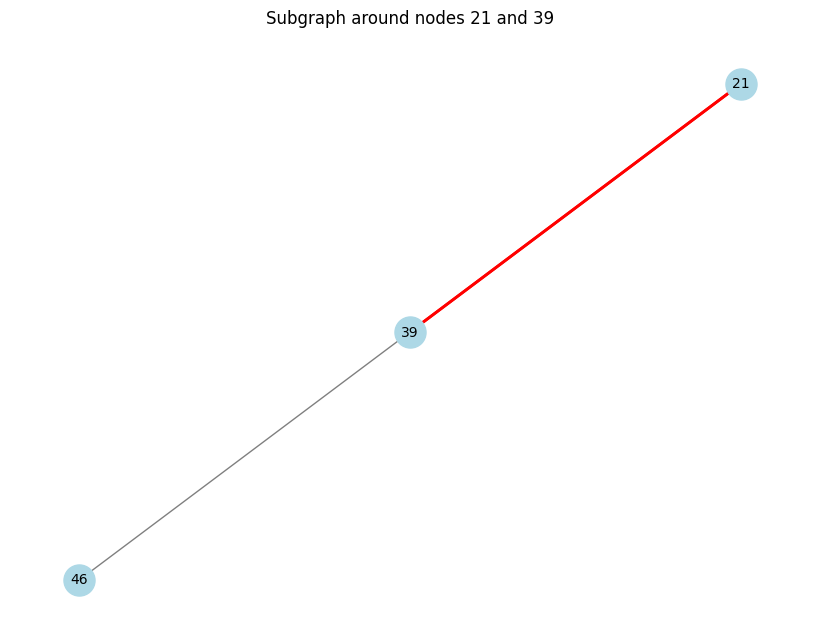


Explanation for link between nodes 21 and 39:
Important Edges: [[21 39]
 [39 21]]

Top important features for source and target nodes in the subgraph:
Node 21:
  race_3: 1.0
  ed_5: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_2: 1.0
  mom_ed_9: 1.0
  rank_E-7: 1.0
  mos_19K: 1.0
  deploy_ever_1: 1.0
Node 39:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_8: 1.0
  mom_ed_10: 1.0
  rank_E-5: 1.0
  mos_19K/Tanker: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  romantic_1
  gender_1
  sexuality_1


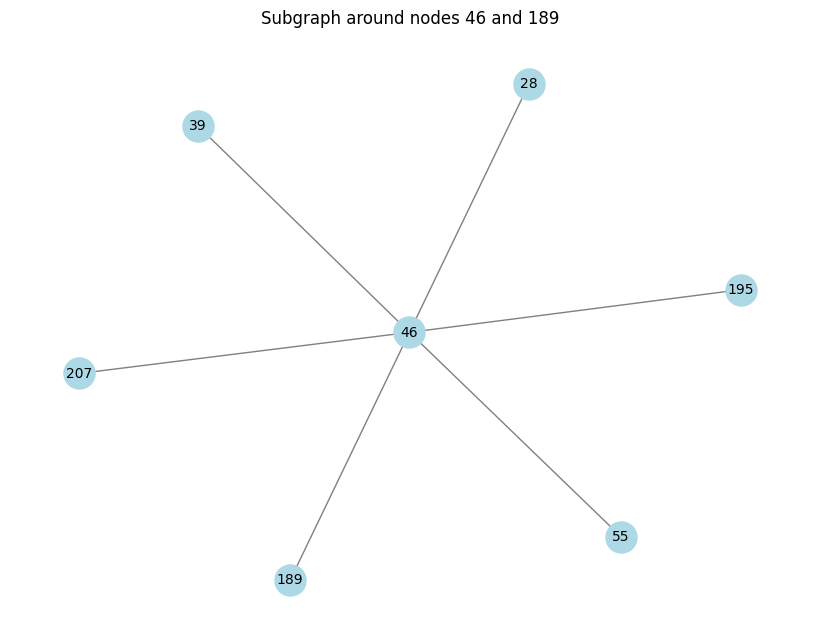


Explanation for link between nodes 46 and 189:
Important Edges: []

Top important features for source and target nodes in the subgraph:
Node 46:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_4: 1.0
  mom_ed_3: 1.0
  rank_E-1: 1.0
  mos_11B: 1.0
  deploy_ever_0: 1.0
Node 189:
  race_5: 1.0
  ed_2: 1.0
  marital_status_3: 1.0
  romantic_0: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_8: 1.0
  mom_ed_5: 1.0
  rank_E-4: 1.0
  mos_11B: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  deploy_ever_0
  mos_11B
  gender_1
  ed_2
  race_5
  sexuality_1


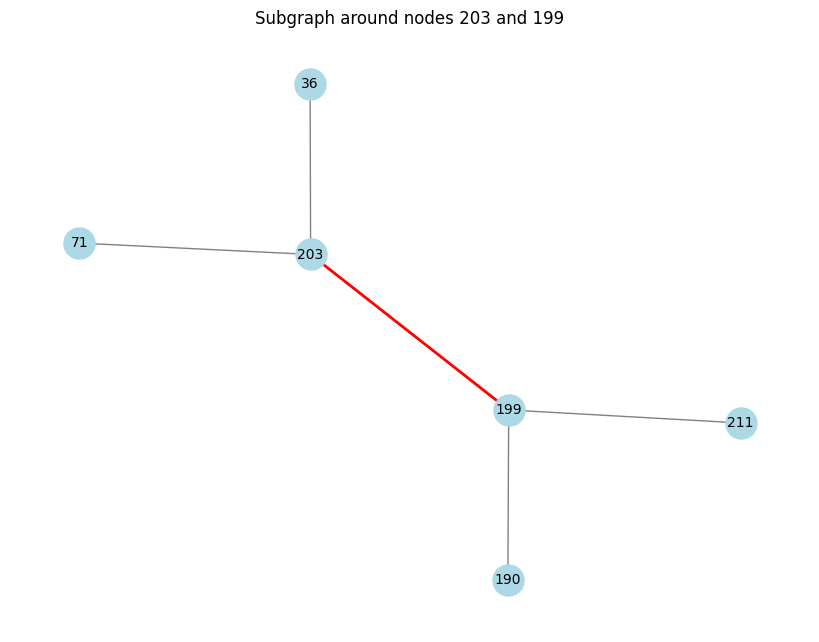


Explanation for link between nodes 203 and 199:
Important Edges: [[203]
 [199]]

Top important features for source and target nodes in the subgraph:
Node 203:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_8: 1.0
  rank_E-4: 1.0
  mos_11B: 1.0
  deploy_ever_1: 1.0
Node 199:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_0: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-3: 1.0
  mos_11B: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  mos_11B
  gender_1
  ed_2
  marital_status_1
  race_5
  sexuality_1
  dad_ed_5


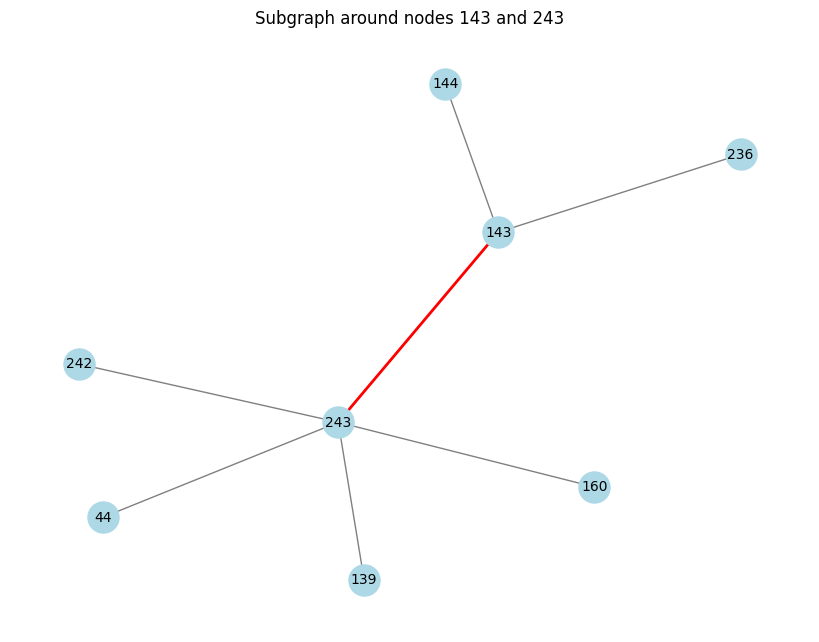


Explanation for link between nodes 143 and 243:
Important Edges: [[143]
 [243]]

Top important features for source and target nodes in the subgraph:
Node 143:
  race_3: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_0: 1.0
  gender_2: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-6: 1.0
  mos_68W: 1.0
  deploy_ever_1: 1.0
Node 243:

Common important features for both source and destination nodes:
  None


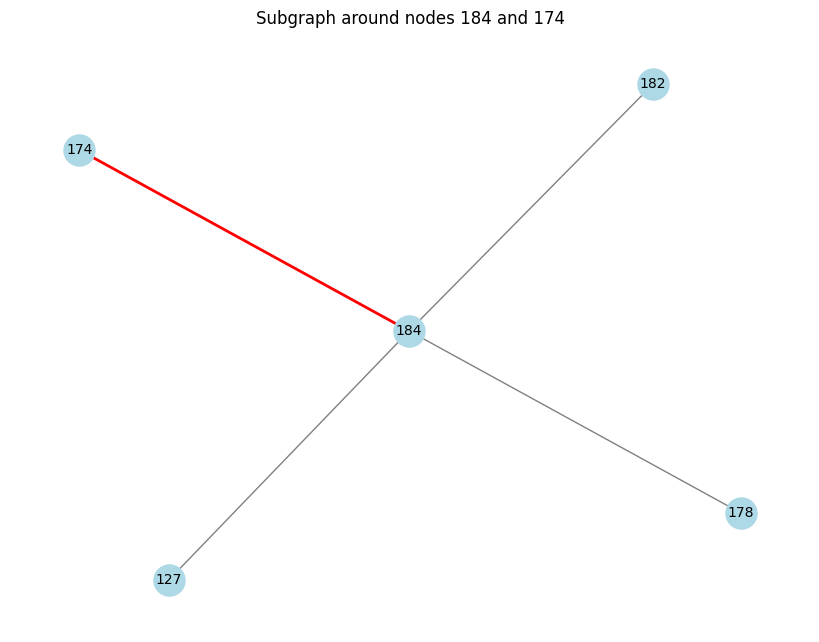


Explanation for link between nodes 184 and 174:
Important Edges: [[184]
 [174]]

Top important features for source and target nodes in the subgraph:
Node 184:
  race_5: 1.0
  ed_2: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-4: 1.0
  mos_11B: 1.0
  deploy_ever_1: 1.0
Node 174:
  race_6: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-5: 1.0
  mos_19k: 1.0
  deploy_ever_1: 1.0

Common important features for both source and destination nodes:
  romantic_1
  gender_1
  ed_2
  mom_ed_5
  sexuality_1
  deploy_ever_1
  dad_ed_5


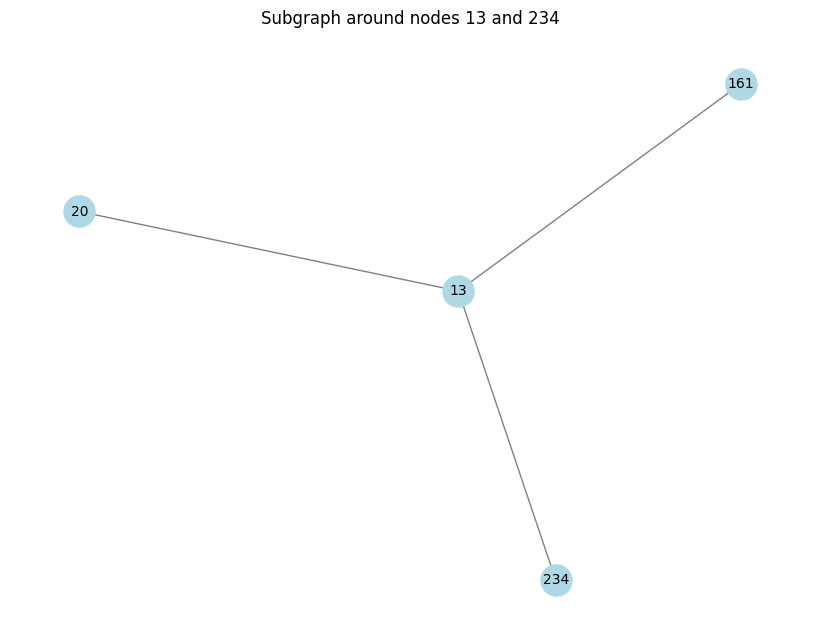


Explanation for link between nodes 13 and 234:
Important Edges: []

Top important features for source and target nodes in the subgraph:
Node 13:
  race_7: 1.0
  ed_6: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-8: 1.0
  mos_19A: 1.0
  deploy_ever_0: 1.0
Node 234:
  race_7: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_0: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_9: 1.0
  rank_E-5: 1.0
  mos_91M: 1.0
  deploy_ever_1: 1.0

Common important features for both source and destination nodes:
  gender_1
  race_7
  marital_status_1
  sexuality_1
  dad_ed_5


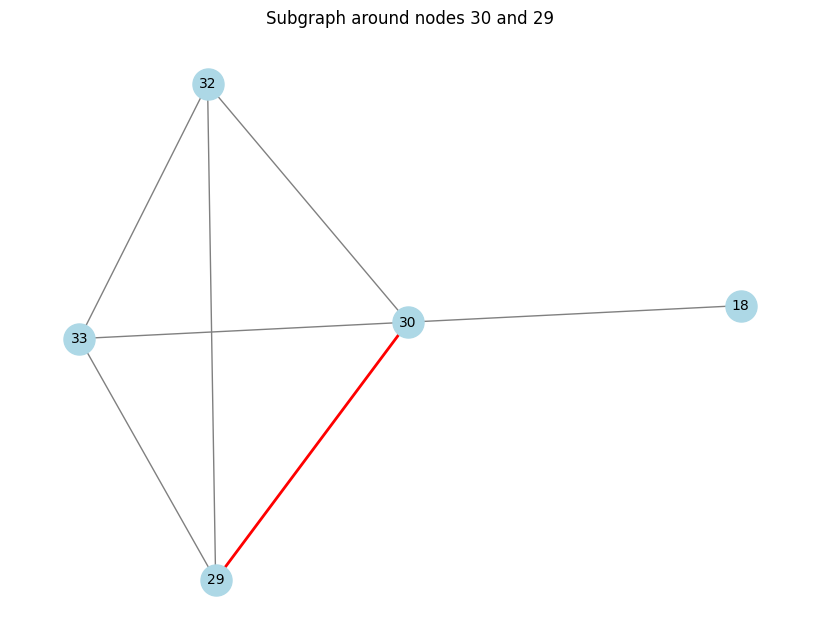


Explanation for link between nodes 30 and 29:
Important Edges: [[30]
 [29]]

Top important features for source and target nodes in the subgraph:
Node 30:
  race_6: 1.0
  ed_2: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_0: 1.0
  mom_ed_8: 1.0
  rank_E-5: 1.0
  mos_11C: 1.0
  deploy_ever_0: 1.0
Node 29:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-3: 1.0
  mos_11B: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  deploy_ever_0
  romantic_1
  gender_1
  ed_2
  sexuality_1


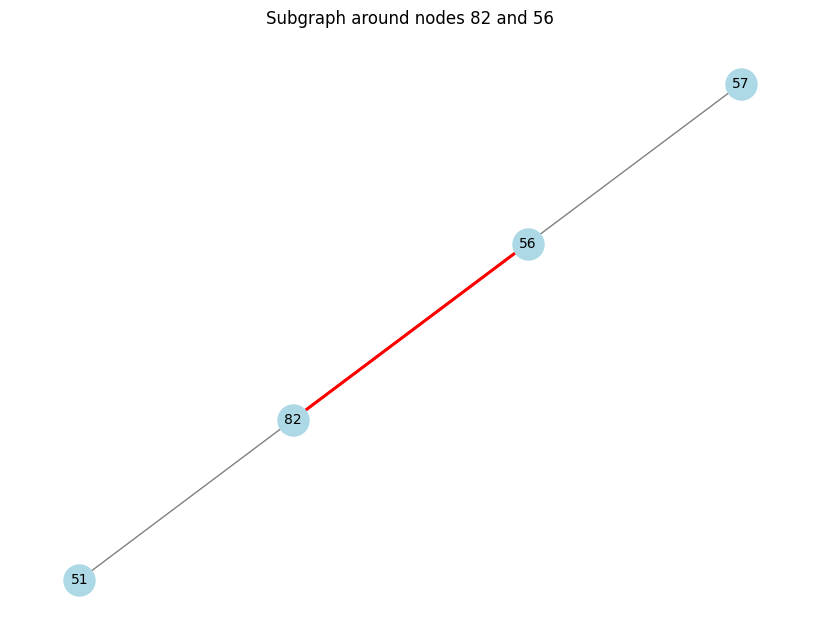


Explanation for link between nodes 82 and 56:
Important Edges: [[82 56]
 [56 82]]

Top important features for source and target nodes in the subgraph:
Node 82:
  deployments: 1.0
  race_5: 1.0
  ed_2: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-7: 1.0
  mos_91A: 1.0
  deploy_ever_1: 1.0
Node 56:
  race_5: 1.0
  ed_2: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_5: 1.0
  mom_ed_5: 1.0
  rank_E-4: 1.0
  mos_88M: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  marital_status_2
  romantic_1
  gender_1
  ed_2
  race_5
  mom_ed_5
  sexuality_1
  dad_ed_5


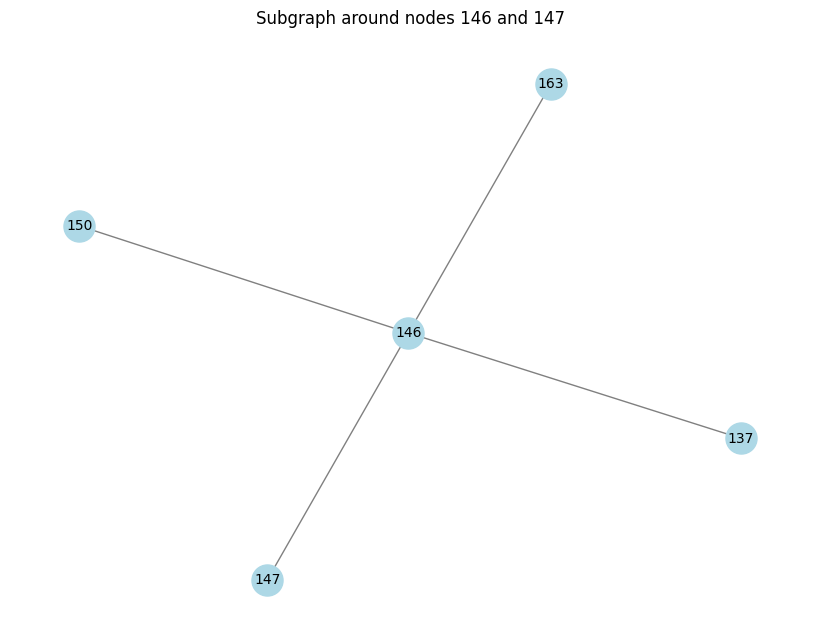


Explanation for link between nodes 146 and 147:
Important Edges: []

Top important features for source and target nodes in the subgraph:
Node 146:
  race_3: 1.0
  ed_8: 1.0
  marital_status_6: 1.0
  romantic_1: 1.0
  gender_2: 1.0
  sexuality_1: 1.0
  dad_ed_11: 1.0
  mom_ed_10: 1.0
  rank_E-5: 1.0
  mos_68W/Medic: 1.0
  deploy_ever_0: 1.0
Node 147:
  race_5: 1.0
  ed_8: 1.0
  marital_status_1: 1.0
  romantic_1: 1.0
  gender_2: 1.0
  sexuality_4: 1.0
  dad_ed_9: 1.0
  mom_ed_9: 1.0
  rank_E-5: 1.0
  mos_68W: 1.0
  deploy_ever_0: 1.0

Common important features for both source and destination nodes:
  deploy_ever_0
  romantic_1
  rank_E-5
  ed_8
  gender_2


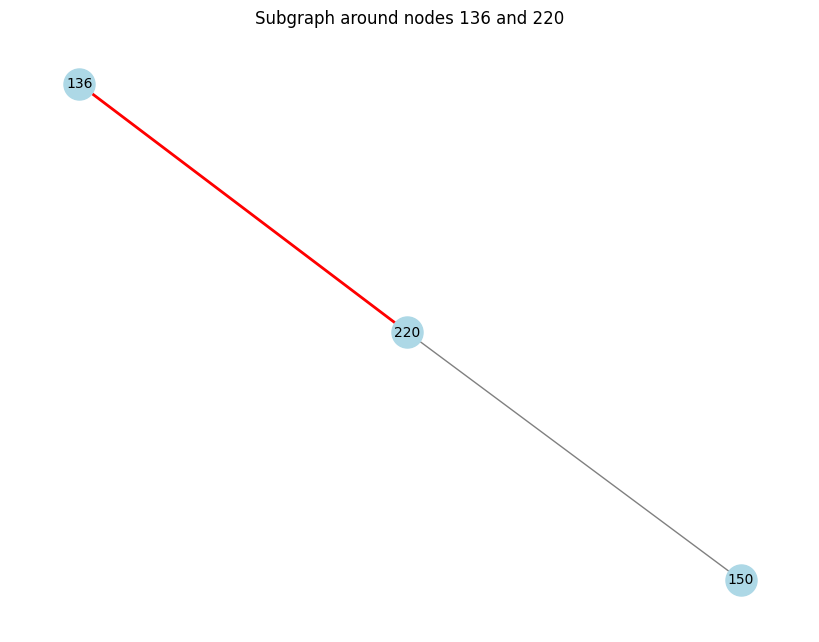


Explanation for link between nodes 136 and 220:
Important Edges: [[220]
 [136]]

Top important features for source and target nodes in the subgraph:
Node 136:
  race_5: 1.0
  ed_2: 1.0
  marital_status_1: 1.0
  romantic_0: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_NaN: 1.0
  mom_ed_11: 1.0
  rank_SOC: 1.0
  mos_68W: 1.0
  deploy_ever_0: 1.0
Node 220:
  race_4: 1.0
  ed_2: 1.0
  marital_status_2: 1.0
  romantic_1: 1.0
  gender_1: 1.0
  sexuality_1: 1.0
  dad_ed_8: 1.0
  mom_ed_5: 1.0
  rank_E-7: 1.0
  mos_19K: 1.0
  deploy_ever_1: 1.0

Common important features for both source and destination nodes:
  gender_1
  ed_2
  sexuality_1


In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.nn import GATConv


class GraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, heads):
        super(GraphGAT, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.conv_out = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv_out(x, edge_index)
        return x

    def encode(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv_out(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphGAT(in_channels=145, hidden_channels=16, out_channels=7, num_layers=1, dropout=0.062244324375886104, heads=8)
model.load_state_dict(torch.load('graphgat_model.pth'))
model.to(device)
model.eval()


x = torch.tensor(df_reindexed.values.astype(np.float32)).to(device)
edge_index = torch.tensor([df['pid'].values, df['alter'].values], dtype=torch.long).to(device)
data = Data(x=x, edge_index=edge_index)


explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=898),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=ModelConfig(
        mode='binary_classification',
        task_level='edge',
        return_type='raw',
    )
)
def explain_link(source_node, dest_node, model, edge_index, data, explainer, feature_names):
    # Convert the data to a NetworkX graph
    G = to_networkx(data, to_undirected=True)
    sub_nodes = [source_node, dest_node] + list(G.neighbors(source_node)) + list(G.neighbors(dest_node))
    sub_G = G.subgraph(sub_nodes).copy()

    x = data.x.clone().detach().requires_grad_(True).to(device)
    edge_index_for_prediction = torch.tensor([[source_node, dest_node], [dest_node, source_node]], dtype=torch.long).t().to(device)

    # Get explanation using the explainer
    explanation = explainer(
        x=x,
        edge_index=edge_index_for_prediction,
        target=None
    )
    node_mask = explanation.node_mask
    edge_mask = explanation.edge_mask

    important_edges = edge_index_for_prediction[:, edge_mask > 0.5].cpu().numpy()
    important_nodes = torch.nonzero(node_mask > 0.5).cpu().numpy().flatten()

    # Plot the subgraph with highlighted important edges
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(sub_G)
    nx.draw(sub_G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    nx.draw_networkx_edges(sub_G, pos, edgelist=important_edges.T, edge_color='red', width=2)
    plt.title(f'Subgraph around nodes {source_node} and {dest_node}')
    plt.show()

    print(f'\nExplanation for link between nodes {source_node} and {dest_node}:')
    print(f"Important Edges: {important_edges}")

    # Find and print the most important features for both source and target nodes
    source_important_features = []
    dest_important_features = []

    print("\nTop important features for source and target nodes in the subgraph:")
    for node in [source_node, dest_node]:
        if node in sub_nodes:
            node_features = x[node].detach().cpu().numpy()
            print(f"Node {node}:")
            important_features = []
            for idx in range(len(node_features)):
                if node_features[idx] == 1:  # Adjust the condition based on how importance is determined
                    feature_name = feature_names[idx]
                    feature_value = node_features[idx]
                    important_features.append(feature_name)
                    print(f"  {feature_name}: {feature_value}")

            if node == source_node:
                source_important_features = important_features
            elif node == dest_node:
                dest_important_features = important_features

    # Identify common important features
    common_features = list(set(source_important_features) & set(dest_important_features))

    print("\nCommon important features for both source and destination nodes:")
    if common_features:
        for feature in common_features:
            print(f"  {feature}")
    else:
        print("  None")

    return edge_mask, node_mask, sub_G


np.random.seed(42)
random_pairs = [(edge_index[0, i].item(), edge_index[1, i].item()) for i in np.random.choice(edge_index.shape[1], 10, replace=False)]


feature_names = data_features_2.columns.tolist()


for source_node, dest_node in random_pairs:
    edge_mask, node_mask, sub_G = explain_link(source_node, dest_node, model, edge_index, data, explainer, feature_names)
